# Dynamic Factor Pricing Model

by Ran You on Aug 16, 2019

This notebook implements the Dynamic Factor Pricing Model (DFPM) proposed by: 

Zhongzhi He, Sahn-Wook Huh, and Bong-Soo Lee, *Dynamic Factor and Asset Pricing*, Journal of Financial and Quantitative Analysis, Vol. 45, No. 3, Jun 2010, pp. 707-737


In [234]:
import sys
!{sys.executable} -m pip install pykalman

In [235]:
import numpy as np
import pandas as pd
from numpy.linalg import inv
from sklearn.linear_model import LinearRegression
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
%matplotlib inline

In [236]:
# Load data
#df = pd.read_csv('/Users/user/dynamic-factor-model/data/F-F_Research_Data_Factors.CSV')
df = pd.read_csv('/Users/polly/Desktop/POLLY/CICC Intern/dynamic-factor-model/data/Monthly_6_Portfolios_Size_BTM.csv')
print(df.columns)

data = df.values[:, 1:]
print(data.shape)

Index(['DATE', 'SMALL LoBM', 'ME1 BM2', 'SMALL HiBM', 'BIG LoBM', 'ME2 BM2',
       'BIG HiBM'],
      dtype='object')
(1112, 6)


In [237]:
factor = pd.read_csv('/Users/polly/Desktop/POLLY/CICC Intern/dynamic-factor-model/data/F-F_Research_Data_Factors.CSV')
factor = factor.iloc[:,1:4]  #X
factor.head()

,MKT-RF,SMB,HML
0,2.96,-2.30,-2.87
1,2.64,-1.40,4.19
2,0.36,-1.32,0.01
3,-3.24,0.04,0.51
4,2.53,-0.20,-0.35


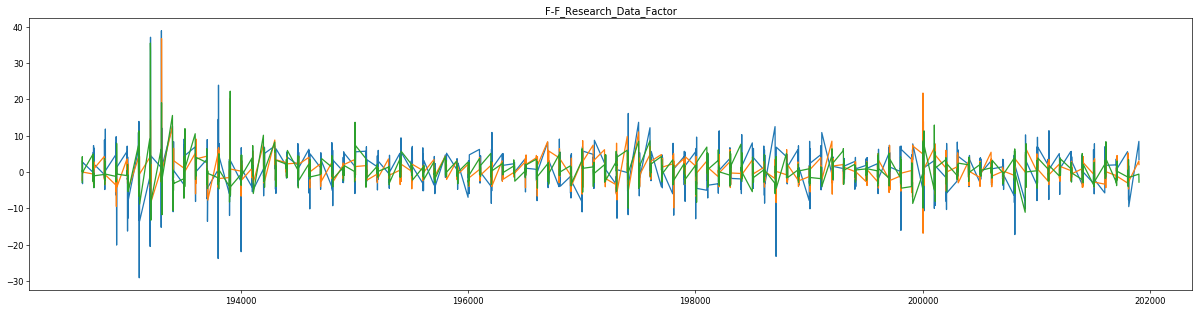

In [238]:
plt.figure(figsize=(25.0,6.0), dpi = 60)
plt.title('F-F_Research_Data_Factor')
plt.plot(df['DATE'],factor['MKT-RF'])
plt.plot(df['DATE'],factor['SMB'])
plt.plot(df['DATE'],factor['HML'])

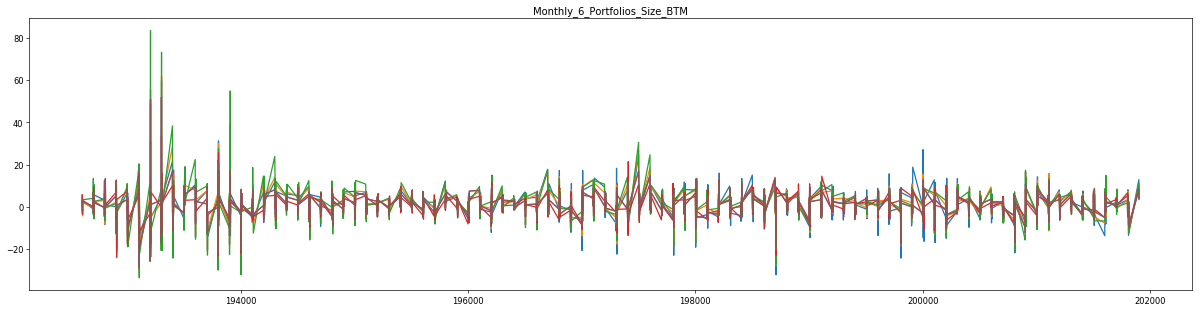

In [239]:
plt.figure(figsize=(25.0,6.0), dpi = 60)
plt.title('Monthly_6_Portfolios_Size_BTM')
plt.plot(df['DATE'],df['SMALL LoBM'])
plt.plot(df['DATE'],df['ME1 BM2'])
plt.plot(df['DATE'],df['SMALL HiBM'])
plt.plot(df['DATE'],df['BIG LoBM'])
plt.plot(df['DATE'],df['ME2 BM2'])
plt.plot(df['DATE'],df['ME2 BM2'])

## Data Cleaning

In [240]:
from scipy import stats
z = np.abs(stats.zscore(df))
mask = np.all((z<2), axis=1)#去除3 sigma以外的行数据
measurements = data[mask]

In [241]:
measurements

array([[  1.3724,   0.9081,  -0.0695,   5.7168,   1.9642,   1.4222],
       [  0.6095,   1.5075,   5.3842,   2.7154,   2.6838,   6.3154],
       [ -2.6779,  -0.1359,  -0.4374,   1.4287,   0.0709,  -0.7967],
       ...,
       [-12.2536, -11.9036, -12.634 ,  -8.3527,  -9.7064, -10.9965],
       [ 12.8222,  10.4413,  11.1025,   8.3738,   8.0332,   8.9019],
       [  6.4804,   5.1181,   3.3772,   3.7468,   3.9507,   1.2016]])

In [242]:
df = df.iloc[mask] #去除3 sigma以外的行数据
factor = factor.iloc[mask] #去除dataframe factor 里面对应的行数据

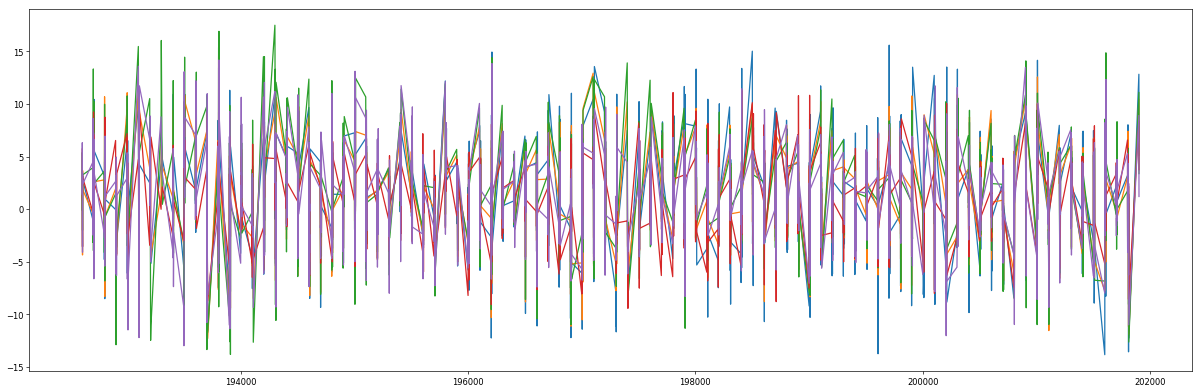

In [243]:
ms = pd.DataFrame(measurements)

plt.figure(figsize=(25.0,8.0), dpi = 60)
plt.plot(df['DATE'],df['SMALL LoBM'])
plt.plot(df['DATE'],df['ME1 BM2'])
plt.plot(df['DATE'],df['SMALL HiBM'])
plt.plot(df['DATE'],df['BIG LoBM'])
plt.plot(df['DATE'],df['BIG HiBM'])

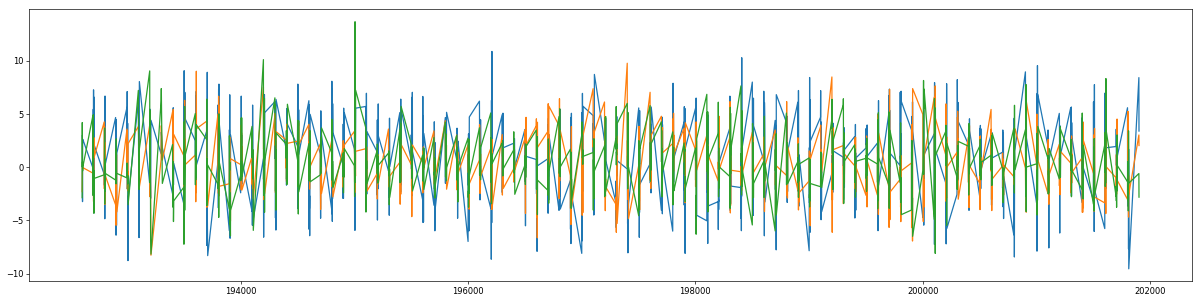

In [244]:
plt.figure(figsize=(25.0,6.0), dpi = 60)
plt.plot(df['DATE'],factor['MKT-RF'])
plt.plot(df['DATE'],factor['SMB'])
plt.plot(df['DATE'],factor['HML'])

## Kalman filter

The Kalman filter addresses the problem of estimating the state (control) of a discrete-time process that is governmed by a linear stochastic difference equation based on some measurements. 

**Kalman filter formalization**

* State equation: 

$x_k = Ax_{k-1} + Bu_k + w_{k-1}$

* Measurement equation: 

$y_k = Hx_k + v_k$

where $x_k\in\mathbb{R}^n$ is the state/control, $u_k\in\mathbb{R}^l$ is the optional control, and $y_k\in\mathbb{R}^m$ is the measurement at time step $k$. 

The $n \times n$ matrix $A$ relates the state at the previous time step to the current state $x_k$, the $n \times l $ matrix $B$ relates the optional control to $x_k$, and the $m \times n$ matrix $H$ relates the state to the measurement $y_k$. 

The random variables $w_k$ and $v_k$ represent the process and measurement noise respectively. They are assumed to be white, normal, and independent of each other: 

$E(w_tw_s^T) = E(v_tv_s^T) = 0$ for $t \neq s$

$E(w_tv_s^T) = 0$ for all $t, s$

**Kalman filter algorithm**

The Kalman filter has two steps: 

* Prediction: 

$X_k^- = A_{k-1}X_{k-1} + B_kU_k$

$P_k^- = A_{k-1}P_{k-1}A_{k-1}^T + Q_{k-1}$

* Update: 

$V_k = Y_k - H_kX_k^-$

$S_k = H_kP_k^-H_k^T + R_k$

$K_k = P_k^-H_k^TS_k^{-1}$

$X_k = X_k^- + K_kV_k$

$P_k = P_k^- - K_kS_kK_k^T$

where

* $X_k^-$: predicted mean of the state at time step $k$ before seeing the measurement
* $P_k^-$: predicted covariacne of the state at time step $k$ before seeing the measurement
* $X_k$: estimated mean of the state at time step $k$ after seeing the measurement
* $P_k^-$: estimated covariance of the state at time step $k$ after seeing the measurement
* $Y_k$: mean of the measurement at time step $k$
* $V_k$: prediction residual at time step $k$
* $S_k$: measurement covariance of prediction at time step $k$
* $K_k$: Kalman gain, which indicates how much the predictions should be corrected at time step $k$ given a new measurement

### Prediction step

This step predicts the mean $X$ and the covariance $P$ of the state of the system at time step $k$. 

Inputs: 
* $X$: estimated mean of the state at the previous step $k$-1
* $P$: estimated covariance of the state at the previous step $k$-1
* $A$: transition matrix
* $Q$: covariance matrix of the process noise
* $B$: effect matrix
* $U$: optional control vector

In [245]:
def kf_predict(X, P, A, Q, B, U): 
    
    X = np.dot(A, X) + np.dot(B, U)
    P = np.dot(A, np.dot(P, A.T)) + Q
    
    return (X, P)

### Update step

This step computes the posterior mean $X$ and covariance $P$ of the state of the system given a new measurement $Y$. 

Inputs: 
* $Y$: new measurement vector
* $H$: measurement matrix
* $R$: covariance matrix of measurement

Outputs: 
* $K$: Kalman Gain matrix
* $M$: mean of predictive distribution of Y
* $S$: covariance matrix of the mean of Y
* $L$: likelihood of measurement


In [246]:
def kf_update(X, P, Y, H, R): 
    
    M = np.dot(H, X)
    S = np.dot(H, np.dot(P, H.T)) + R
    
    K = np.dot(P, np.dot(H.T, inv(S))) # Kalman gain
    
    X = X + np.dot(K, Y - M)
    P = P - np.dot(K, np.dot(S, K.T))
    
    L = gauss_pdf(Y, M, S)
    
    return (X, P, K, M, S, L)

In [247]:
def gauss_pdf(X, M, S): 
    
    if M.shape[1] == 1: 
        
        DX = X - np.tile(M, X.shape[1])
        E = 0.5 * np.sum(DX * (np.dot(inv(S), DX)), axis=0)
        E = E + 0.5 * M.shape[0] + np.log(2 * np.pi) + 0.5 * np.log(det(S))
        P = np.exp(-E)
    
    elif X.shape[1] == 1: 
        
        DX = np.tile(X, M.shape[1]) - M
        E = 0.5 * np.sum(DX * (np.dot(inv(S), DX)), axis=0)
        E = E + 0.5 * M.shape[0] * np.log(2 * np.pi) + 0.5 * np.log(det(S))
        P = np.exp(-E)
    
    else: 
        DX = X - M
        E = 0.5 * np.dot(DX.T, np.dot(inv(S), DX))
        E = E + 0.5 * M.shape[0] * np.log(2 * np.pi) + 0.5 * np.log(det(S))
        P = np.exp(-E)
    
    return (P[0], E[0])

## Dynamic Factor Pricing Model (DFPM)

$y_t\in\mathbb{R}^M$, $x_t\in\mathbb{R}^N$

* Observation/Measurement equation: 

$y_t = C x_t + v_t$

* Transition/State equation: 

$x_t = A x_{t-1} + w_t$

We make the conventional assumptions that $w_t$ and $v_t$ follow joint normal distributions, with their covariance matrices given by

$E(w_tw_s^T) = Q$ for $t \neq s$ and 0 otherwise

$E(v_tv_s^T) = R$ for $t \neq s$ and 0 otherwise

$E(w_tv_s) = 0$ for all $t$ and $s$

### Expectation-Maximization (EM) Algorithm
* E-step: Use a Kalman filter or a minimum-variance smoother with current parameter estimates to obtain updated state estimates.
* M-step: Use the filtered or smoothed state estimates with maximum-likelihood calculations to obtain updated parameter estimates.

### Estimating DFPM

In [248]:
T = 50 # Number of iterations
N = 3 # Number of factors
M = 6 # Number of measurements (portfolios)

# Initialize the parameter matrices
A = np.ones((N, N)) # transition matrix
C = np.ones((M, N)) # observation matrix

print(measurements.shape, A.shape, C.shape)

(1017, 6) (3, 3) (6, 3)


In [249]:
# Apply the EM algorithm for optimization
kf = KalmanFilter(transition_matrices=A, observation_matrices=C, 
                  em_vars=['transition_matrices', 'transition_covariance', 
                           'observation_matrices', 'observation_covariance', 
                          ])
kf = kf.em(measurements, n_iter=50)

In [250]:
# Apply the Kalman filter and the Kalman smoother for prediction
(filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)
print(filtered_state_means.shape, filtered_state_covariances.shape)
print(smoothed_state_means.shape, smoothed_state_covariances.shape)

(1017, 3) (1017, 3, 3)
(1017, 3) (1017, 3, 3)


In [251]:
fs = pd.DataFrame(filtered_state_means)
ss = pd.DataFrame(smoothed_state_means)

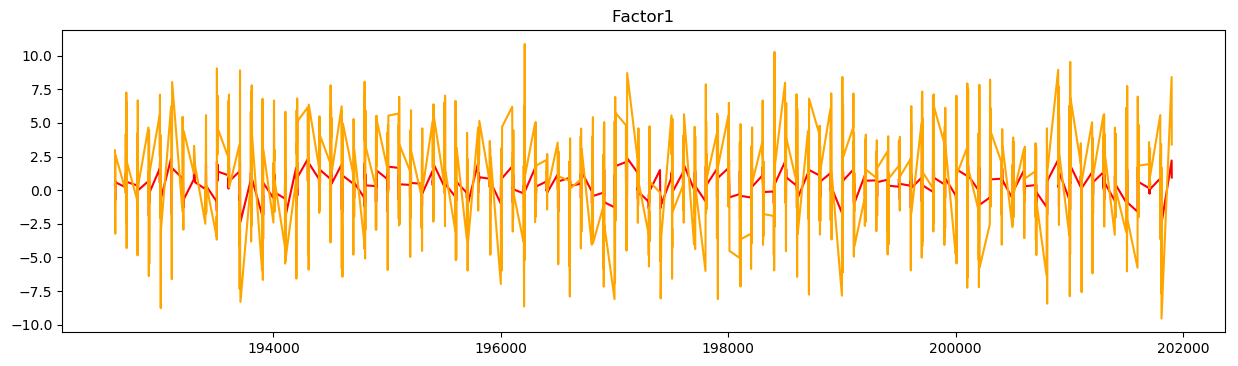

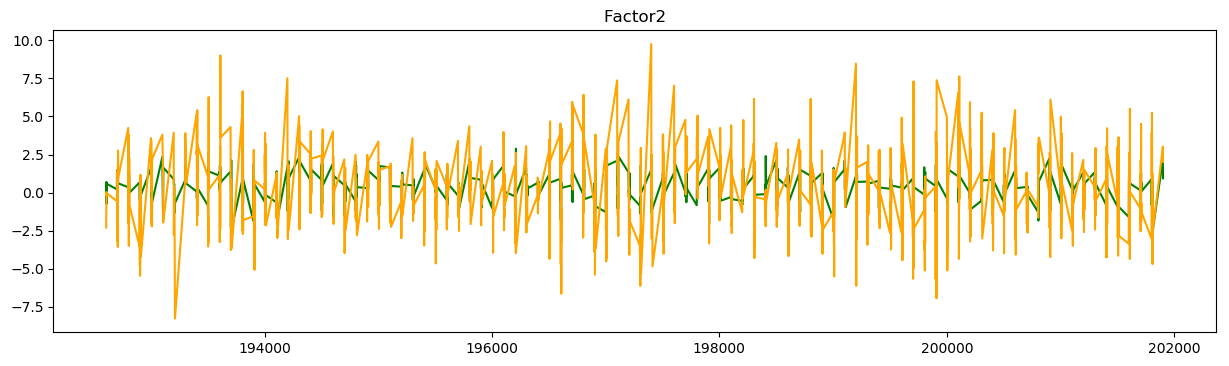

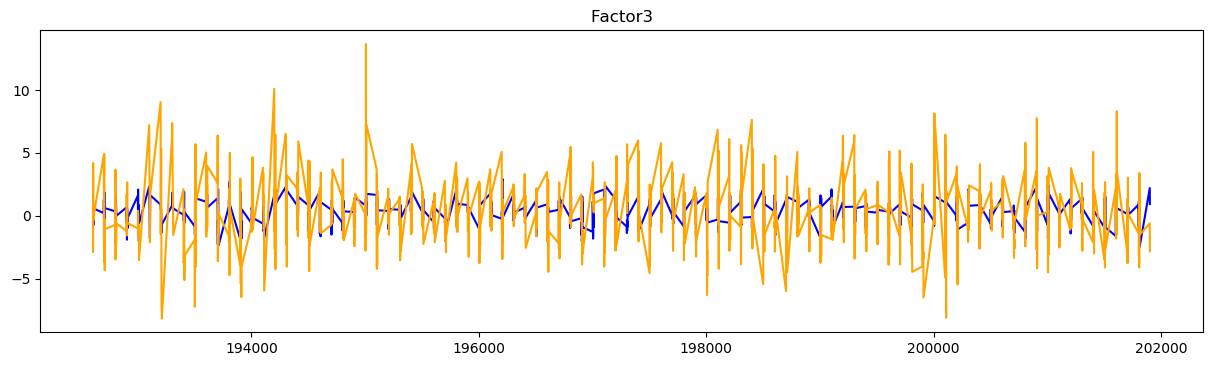

In [252]:
col = ['red','green','blue','orange']
for i in range(3):
    plt.figure(figsize=(15,4.0), dpi = 100)
    plt.title('Factor'+ str(i+1))
    plt.plot(df['DATE'],fs.iloc[:,i],color=col[i])
    plt.plot(df['DATE'],factor.iloc[:,i],color=col[3])

# Another Method for DFM

### Setting Parameter
A
C
v
w
Initial status of X and Y

In [216]:
A = kf.transition_matrices # A 
A

array([[0.05267588, 0.05267588, 0.05267588],
       [0.05267588, 0.05267588, 0.05267588],
       [0.05267588, 0.05267588, 0.05267588]])

In [254]:
C = kf.observation_matrices #C
C

array([[1.65049227, 1.65049227, 1.65049227],
       [1.54455778, 1.54455778, 1.54455778],
       [1.66815307, 1.66815307, 1.66815307],
       [1.13662414, 1.13662414, 1.13662414],
       [1.12700608, 1.12700608, 1.12700608],
       [1.39488917, 1.39488917, 1.39488917]])

In [256]:
x0 = np.array([factor.iloc[0]]) # x_0
x0 = x0.T
x0

array([[ 2.96],
       [-2.3 ],
       [-2.87]])

In [257]:
df1 = df.iloc[:,1:7]
y0 = np.array([df1.iloc[0]])   # y_0
y0 = y0.T
y0

array([[ 1.3724],
       [ 0.9081],
       [-0.0695],
       [ 5.7168],
       [ 1.9642],
       [ 1.4222]])

In [258]:
#Kalman Filter

P0 = np.diag([1,1,1])
setK = []
updX = [x0]
updP = [P0]
A = kf.transition_matrices
C = kf.observation_matrices
R = np.diag([1,1,1,1,1,1])

for i in range(1017):
    tmpX = np.dot(A, updX[i]) + np.array([np.random.randn(3)*2]).T
    tmpP = np.dot(A, np.dot(updP[i], A.T))
    tmpK = np.dot(np.dot(tmpP, C.T),np.linalg.inv(np.dot(C, np.dot(tmpP, C.T))+R))
    yi = np.array([df1.iloc[i]])
    tmpUpX = tmpX + np.dot(tmpK, yi.T - np.dot(C, tmpX))
    tmp = np.diag([1,1,1]) - np.dot(tmpK, C)
    tmpUpP = np.dot(tmp, tmpP)
    updX.append(tmpUpX)
    updP.append(tmpUpP)

In [259]:
X1 = []
X2 = []
X3 = []
for i in range(1017):
    X1.append(updX[i+1][0][0])
    X2.append(updX[i+1][1][0])
    X3.append(updX[i+1][2][0])

X1 = pd.Series(X1)
X2 = pd.Series(X2)
X3 = pd.Series(X3)

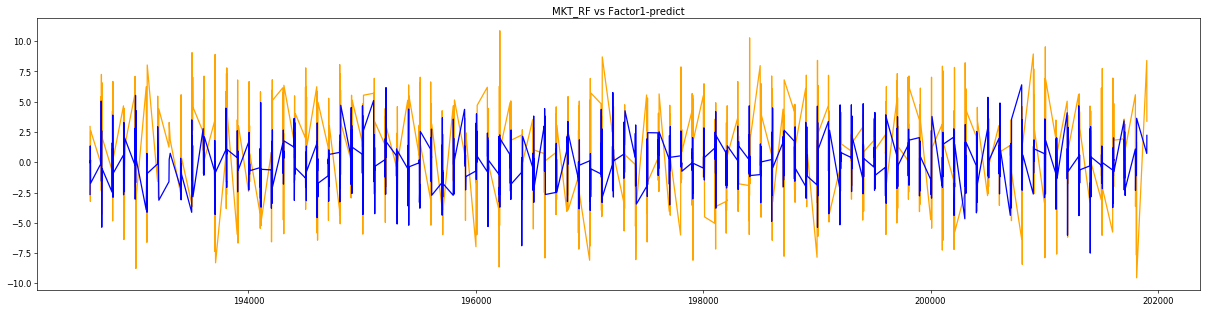

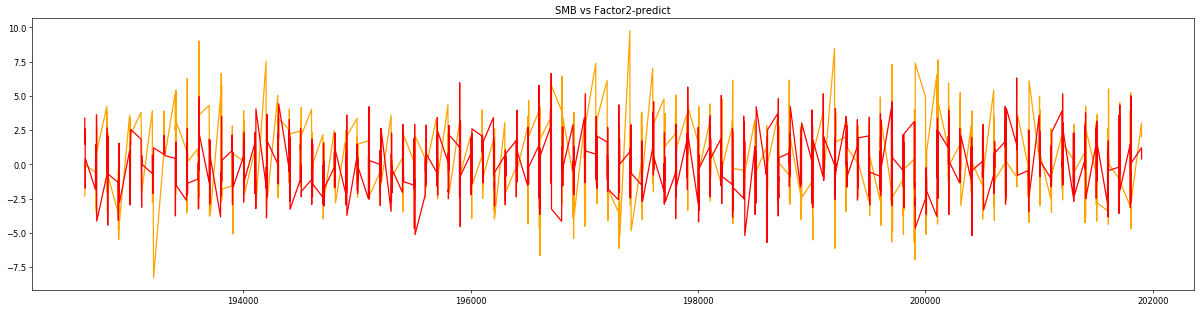

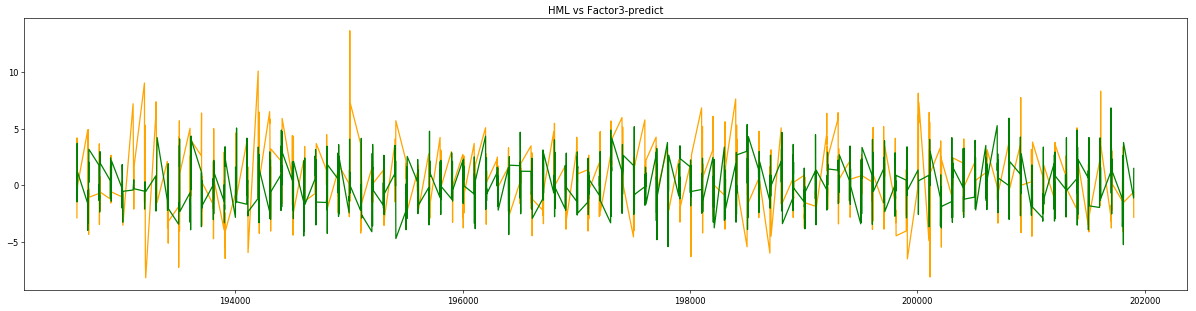

In [260]:
plt.figure(figsize=(25.0,6.0), dpi = 60)
plt.title('MKT_RF vs Factor1-predict')
plt.plot(df['DATE'],factor['MKT-RF'],color='orange')
plt.plot(df['DATE'],X1,color='blue')

plt.figure(figsize=(25.0,6.0), dpi = 60)
plt.title('SMB vs Factor2-predict')
plt.plot(df['DATE'],factor['SMB'],color='orange')
plt.plot(df['DATE'],X2,color='red')

plt.figure(figsize=(25.0,6.00), dpi = 60)
plt.title('HML vs Factor3-predict')
plt.plot(df['DATE'],factor['HML'],color='orange')
plt.plot(df['DATE'],X3, color='green')